In [25]:
### IMPORTS

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
from pymc3 import math
from scipy import stats
import theano as T
from scipy import stats
from scipy.special import expit as logistic
sns.set_context('talk')

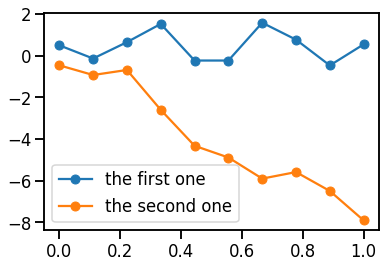

In [2]:
np.random.seed(42)
x = np.linspace(0, 1, 10)
y = np.random.normal(0, 1, len(x))
plt.plot(x, y, 'o-', label='the first one')
y = np.zeros_like(x)
for i in range(len(x)):
    y[i] = np.random.normal(y[i-1], 1)
plt.plot(x, y, 'o-', label='the second one')
plt.legend()

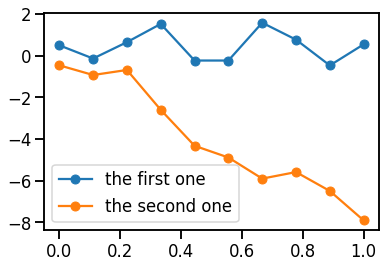

In [6]:
np.random.seed(42)
x = np.linspace(0, 1, 10)
y = np.random.multivariate_normal(np.zeros_like(x), np.eye(len(x))) #alternatively giving more dimensions
plt.plot(x, y, 'o-', label='the first one')
y = np.zeros_like(x)
for i in range(len(x)):
    y[i] = np.random.normal(y[i-1], 1)
plt.plot(x, y, 'o-', label='the second one')
plt.legend()

In [3]:
def exp_quad_kernel(x, knots, ℓ=1): #also known as the Gaussian kernel
    """exponentiated quadratic kernel"""
    return np.array([np.exp(-(x-k)**2 / (2*ℓ**2)) for k in knots])

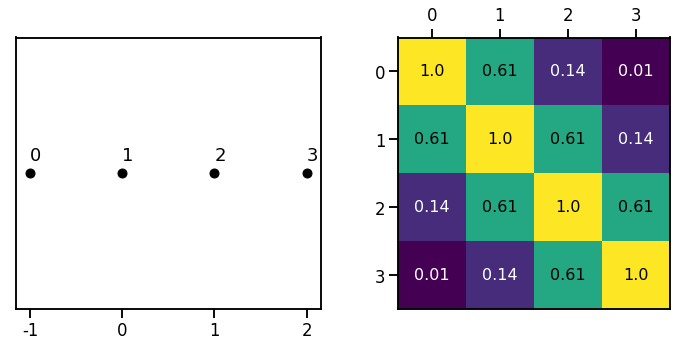

In [10]:
data = np.array([-1, 0, 1, 2])
cov = exp_quad_kernel(data, data, 1)
_, ax = plt.subplots(1, 2, figsize=(12, 5))
ax = np.ravel(ax)
ax[0].plot(data, np.zeros_like(data), 'ko')
ax[0].set_yticks([])
for idx, i in enumerate(data):
    ax[0].text(i, 0+0.005, idx)
ax[0].set_xticks(data)
ax[0].set_xticklabels(np.round(data, 2))
#ax[0].set_xticklabels(np.round(data, 2), rotation=70)
ax[1].grid(False)
im = ax[1].imshow(cov)
colors = ['w', 'k']
for i in range(len(cov)):
    for j in range(len(cov)):
        ax[1].text(j, i, round(cov[i, j], 2),
        color=colors[int(im.norm(cov[i, j]) > 0.5)],
        ha='center', va='center', fontdict={'size': 16})
ax[1].set_xticks(range(len(data)))
ax[1].set_yticks(range(len(data)))
ax[1].xaxis.tick_top()

Text(-0.03, 0.5, 'f(x)')

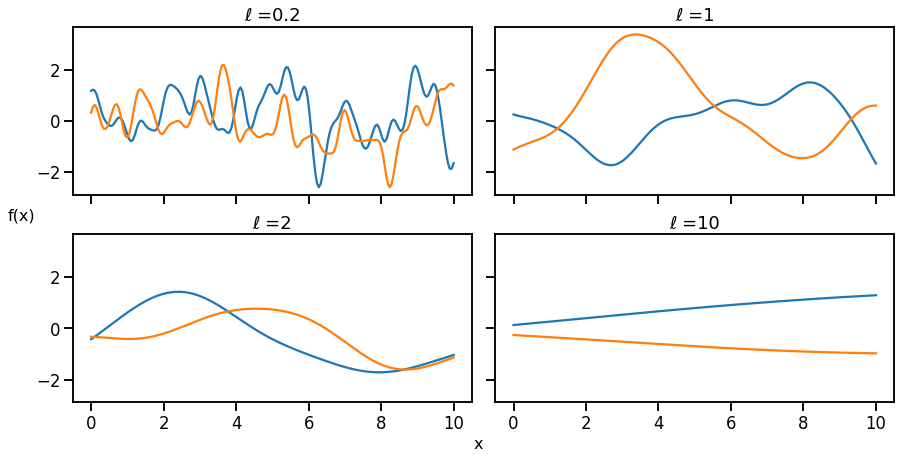

In [11]:
np.random.seed(24)
test_points = np.linspace(0, 10, 200)
fig, ax = plt.subplots(2, 2, figsize=(12, 6), sharex=True, sharey=True, constrained_layout=True)
ax = np.ravel(ax)

for idx, ℓ in enumerate((0.2, 1, 2, 10)):
    cov = exp_quad_kernel(test_points, test_points, ℓ)
    ax[idx].plot(test_points, stats.multivariate_normal.rvs(cov=cov,
    size=2).T)
    ax[idx].set_title(f'ℓ ={ℓ}')
fig.text(0.51, -0.03, 'x', fontsize=16)
fig.text(-0.03, 0.5, 'f(x)', fontsize=16)

Text(0, 0.5, 'f(x)')

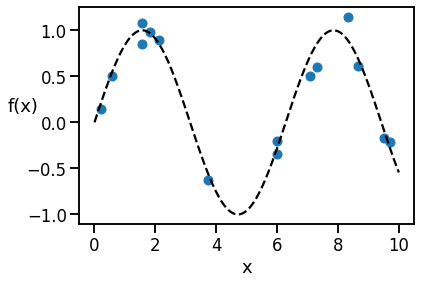

In [12]:
np.random.seed(42)
x = np.random.uniform(0, 10, size=15)
y = np.random.normal(np.sin(x), 0.1)
plt.plot(x, y, 'o')
true_x = np.linspace(0, 10, 200)
plt.plot(true_x, np.sin(true_x), 'k--')
plt.xlabel('x')
plt.ylabel('f(x)', rotation=0)

In [13]:
# A one dimensional column vector of inputs.
X = x[:, None]
with pm.Model() as model_reg:
    # hyperprior for lengthscale kernel parameter
    ℓ = pm.Gamma('ℓ', 2, 0.5)
    # instantiate a covariance function
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ)
    # instantiate a GP prior
    gp = pm.gp.Marginal(cov_func=cov)
    # prior
    ϵ = pm.HalfNormal('ϵ', 25)
    # likelihood
    y_pred = gp.marginal_likelihood('y_pred', X=X, y=y, noise=ϵ)

In [14]:
with model_reg:
    trace_reg = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, ℓ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.


array([[<AxesSubplot:title={'center':'ℓ'}>,
        <AxesSubplot:title={'center':'ℓ'}>],
       [<AxesSubplot:title={'center':'ϵ'}>,
        <AxesSubplot:title={'center':'ϵ'}>]], dtype=object)

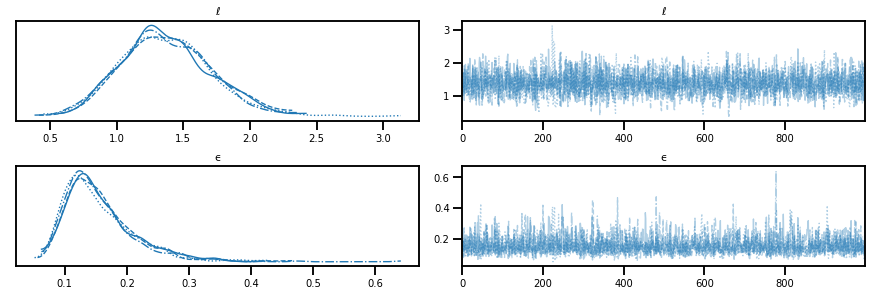

In [15]:
az.plot_trace(trace_reg)

Using this new revolutionary technique, we can get posteriors of *functions*, which can be evaluated on new data.

In [16]:
X_new = np.linspace(np.floor(x.min()), np.ceil(x.max()), 100)[:,None] #define new data that the model should predict on
with model_reg:
    f_pred = gp.conditional('f_pred', X_new) #get f_pred, which is our predicted functions 

In [19]:
with model_reg:
    pred_samples = pm.sample_posterior_predictive(trace_reg, var_names=["f_pred"], samples=82) #proper syntax as of 2021

Text(0.5, 0, 'X')

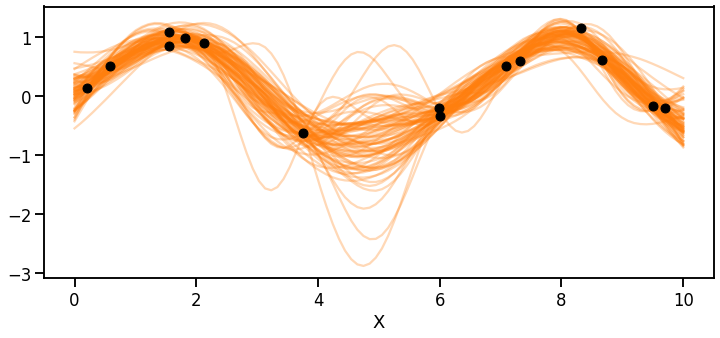

In [20]:
_, ax = plt.subplots(figsize=(12,5))
ax.plot(X_new, pred_samples['f_pred'].T, 'C1-', alpha=0.3)
ax.plot(X, y, 'ko')
ax.set_xlabel('X')

Text(0, 0.5, 'f(x)')

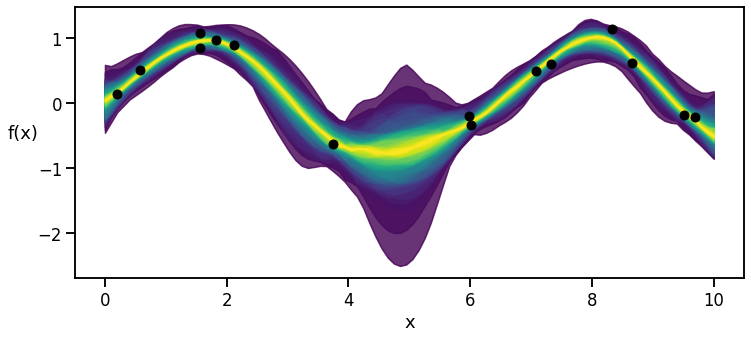

In [21]:
_, ax = plt.subplots(figsize=(12,5))
pm.gp.util.plot_gp_dist(ax, pred_samples['f_pred'], X_new,
palette='viridis', plot_samples=False); #DEN HER BADBOY HVAD SKER DER
ax.plot(X, y, 'ko')
ax.set_xlabel('x')
ax.set_ylabel('f(x)', rotation=0, labelpad=15)

Text(0.5, 0, 'X')

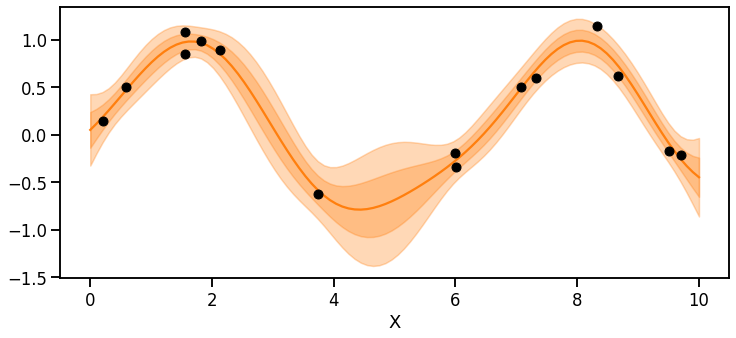

In [22]:
_, ax = plt.subplots(figsize=(12,5))
point = {'ℓ': trace_reg['ℓ'].mean(), 'ϵ': trace_reg['ϵ'].mean()}
mu, var = gp.predict(X_new, point=point, diag=True)
sd = var**0.5
ax.plot(X_new, mu, 'C1')
ax.fill_between(X_new.flatten(),
mu - sd, mu + sd,color="C1",
alpha=0.3)
ax.fill_between(X_new.flatten(),
mu - 2*sd, mu + 2*sd,
color="C1",
alpha=0.3)
ax.plot(X, y, 'ko')
ax.set_xlabel('X')

## McElreath Example

In [23]:
islands_dist = pd.read_csv('../data/islands_dist.csv',
sep=',', index_col=0)
islands_dist.round(1)

,Ml,Ti,SC,Ya,Fi,Tr,Ch,Mn,To,Ha
Malekula,0.0,0.5,0.6,4.4,1.2,2.0,3.2,2.8,1.9,5.7
Tikopia,0.5,0.0,0.3,4.2,1.2,2.0,2.9,2.7,2.0,5.3
Santa Cruz,0.6,0.3,0.0,3.9,1.6,1.7,2.6,2.4,2.3,5.4
Yap,4.4,4.2,3.9,0.0,5.4,2.5,1.6,1.6,6.1,7.2
Lau Fiji,1.2,1.2,1.6,5.4,0.0,3.2,4.0,3.9,0.8,4.9
Trobriand,2.0,2.0,1.7,2.5,3.2,0.0,1.8,0.8,3.9,6.7
Chuuk,3.2,2.9,2.6,1.6,4.0,1.8,0.0,1.2,4.8,5.8
Manus,2.8,2.7,2.4,1.6,3.9,0.8,1.2,0.0,4.6,6.7
Tonga,1.9,2.0,2.3,6.1,0.8,3.9,4.8,4.6,0.0,5.0
Hawaii,5.7,5.3,5.4,7.2,4.9,6.7,5.8,6.7,5.0,0.0


In [24]:
islands = pd.read_csv('../data/islands.csv', sep=',')
islands.head().round(1)

,culture,population,contact,total_tools,mean_TU,lat,lon,lon2,logpop
0,Malekula,1100,low,13,3.2,-16.3,167.5,-12.5,7.0
1,Tikopia,1500,low,22,4.7,-12.3,168.8,-11.2,7.3
2,Santa Cruz,3600,low,24,4.0,-10.7,166.0,-14.0,8.2
3,Yap,4791,high,43,5.0,9.5,138.1,-41.9,8.5
4,Lau Fiji,7400,high,33,5.0,-17.7,178.1,-1.9,8.9


In [25]:
islands_dist_sqr = islands_dist.values**2
culture_labels = islands.culture.values
index = islands.index.values
log_pop = islands.logpop
total_tools = islands.total_tools
x_data = [islands.lat.values[:, None], islands.lon.values[:, None]]

In [26]:
with pm.Model() as model_islands:
    η = pm.HalfCauchy('η', 1)
    ℓ = pm.HalfCauchy('ℓ', 1)
    cov = η * pm.gp.cov.ExpQuad(1, ls=ℓ)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior('f', X=islands_dist_sqr)
    α = pm.Normal('α', 0, 10)
    β = pm.Normal('β', 0, 1)
    μ = pm.math.exp(α + f[index] + β * log_pop)
    tt_pred = pm.Poisson('tt_pred', μ, observed=total_tools)
    trace_islands = pm.sample(1000, tune=1000)

C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\pymc3\gp\cov.py:92: UserWarning: Only 1 column(s) out of 10 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α, f_rotated_, ℓ, η]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 159 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9102467040308384, but should be close to 0.8. Try to increase the number of tuning steps.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Text(0, 0.5, 'covariance')

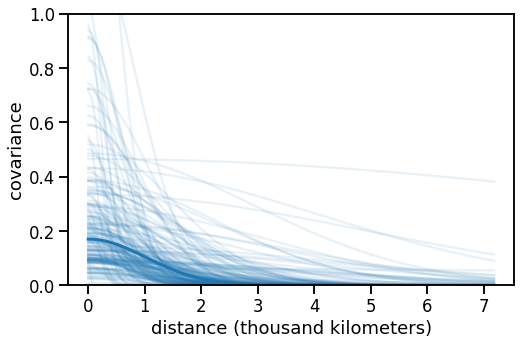

In [27]:
trace_η = trace_islands['η']
trace_ℓ = trace_islands['ℓ']
_, ax = plt.subplots(1, 1, figsize=(8, 5))
xrange = np.linspace(0, islands_dist.values.max(), 100)
ax.plot(xrange, np.median(trace_η) *
np.exp(-np.median(trace_ℓ) * xrange**2), lw=3)
ax.plot(xrange, (trace_η[::20][:, None] * np.exp(- trace_ℓ[::20][:, None] *
xrange**2)).T,
'C0', alpha=.1)
ax.set_ylim(0, 1)
ax.set_xlabel('distance (thousand kilometers)')
ax.set_ylabel('covariance')

In [28]:
# compute posterior median covariance among societies
Σ = np.median(trace_η) * (np.exp(-np.median(trace_ℓ) * islands_dist_sqr))
# convert to correlation matrix
Σ_post = np.diag(np.diag(Σ)**-0.5)
ρ = Σ_post @ Σ @ Σ_post
ρ = pd.DataFrame(ρ, index=islands_dist.columns,columns=islands_dist.columns)
ρ.round(2)

,Ml,Ti,SC,Ya,Fi,Tr,Ch,Mn,To,Ha
Ml,1.00,0.90,0.83,0.00,0.48,0.14,0.01,0.02,0.19,0.0
Ti,0.90,1.00,0.95,0.00,0.48,0.14,0.02,0.03,0.16,0.0
SC,0.83,0.95,1.00,0.00,0.31,0.24,0.04,0.07,0.08,0.0
Ya,0.00,0.00,0.00,1.00,0.00,0.05,0.31,0.28,0.00,0.0
Fi,0.48,0.48,0.31,0.00,1.00,0.01,0.00,0.00,0.76,0.0
Tr,0.14,0.14,0.24,0.05,0.01,1.00,0.21,0.71,0.00,0.0
Ch,0.01,0.02,0.04,0.31,0.00,0.21,1.00,0.49,0.00,0.0
Mn,0.02,0.03,0.07,0.28,0.00,0.71,0.49,1.00,0.00,0.0
To,0.19,0.16,0.08,0.00,0.76,0.00,0.00,0.00,1.00,0.0
Ha,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0


(10.0, 73.0)

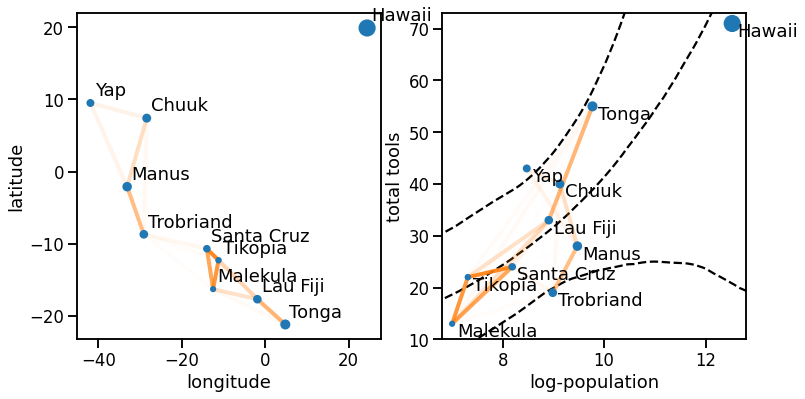

In [31]:
# scale point size to logpop
logpop = np.copy(log_pop)
logpop /= logpop.max()
psize = np.exp(logpop*5.5)
log_pop_seq = np.linspace(6, 14, 100)
lambda_post = np.exp(trace_islands['α'][:, None] +
trace_islands['β'][:, None] * log_pop_seq)
_, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(islands.lon2, islands.lat, psize, zorder=3)
ax[1].scatter(islands.logpop, islands.total_tools, psize, zorder=3)
for i, itext in enumerate(culture_labels):
    ax[0].text(islands.lon2[i]+1, islands.lat[i]+1, itext)
    ax[1].text(islands.logpop[i]+.1, islands.total_tools[i]-2.5, itext)
ax[1].plot(log_pop_seq, np.median(lambda_post, axis=0), 'k--')
az.plot_hpd(log_pop_seq, lambda_post, fill_kwargs={'alpha':0},plot_kwargs={'color':'k', 'ls':'--', 'alpha':1})
for i in range(10):
    for j in np.arange(i+1, 10):
        ax[0].plot((islands.lon2[i], islands.lon2[j]),
        (islands.lat[i], islands.lat[j]), 'C1-',
        alpha=ρ.iloc[i, j]**2, lw=4)
        ax[1].plot((islands.logpop[i], islands.logpop[j]),
        (islands.total_tools[i], islands.total_tools[j]), 'C1-',
        alpha=ρ.iloc[i, j]**2, lw=4)
ax[0].set_xlabel('longitude')
ax[0].set_ylabel('latitude')
ax[1].set_xlabel('log-population')
ax[1].set_ylabel('total tools')
ax[1].set_xlim(6.8, 12.8)
ax[1].set_ylim(10, 73)

## Classification using Bayes on Irises 

In [32]:
iris = pd.read_csv('../data/iris.csv')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [33]:
df = iris.query("species == ('setosa', 'versicolor')")
y = pd.Categorical(df['species']).codes
x_1 = df['sepal_length'].values
X_1 = x_1[:, None]

In [56]:
with pm.Model() as model_iris:
    ℓ = pm.Gamma('ℓ', 2, 0.5)
    cov = pm.gp.cov.ExpQuad(1, ℓ)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=X_1)
    # logistic inverse link function and Bernoulli likelihood
    y_ = pm.Bernoulli("y", p=pm.math.sigmoid(f), observed=y)
    trace_iris = pm.sample(1000, chains=1,compute_convergence_checks=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [f_rotated_, ℓ]


C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\pymc3\math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 51 seconds.


In [57]:
X_new = np.linspace(np.floor(x_1.min()), np.ceil(x_1.max()), 200)[:, None]
with model_iris:
    f_pred = gp.conditional('f_pred', X_new)
    pred_samples = pm.sample_posterior_predictive(trace_iris, var_names = ["f_pred"], samples=1000) #linalg error - seems quite hard to solve

LinAlgError: Matrix is not positive definite

In [46]:
def find_midpoint(array1, array2, value):
    """
    This should be a proper docstring :-)
    """
    array1 = np.asarray(array1)
    idx0 = np.argsort(np.abs(array1 - value))[0]
    idx1 = idx0 - 1 if array1[idx0] > value else idx0 + 1
    if idx1 == len(array1):
        idx1 -= 1
    return (array2[idx0] + array2[idx1]) / 2

KeyError: 'f_pred'

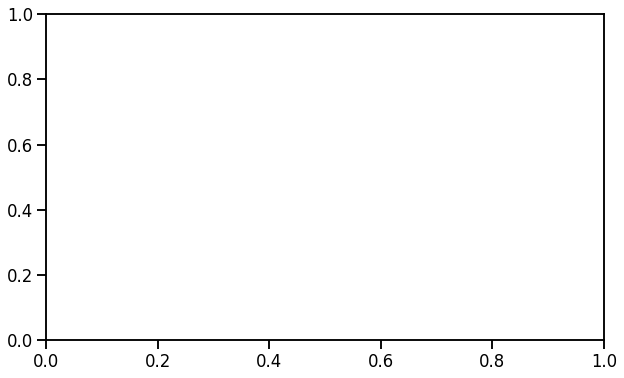

In [53]:
_, ax = plt.subplots(figsize=(10, 6))
fp = logistic(pred_samples['f_pred'])
fp_mean = np.mean(fp, 0)
ax.plot(X_new[:, 0], fp_mean)
# plot the data (with some jitter) and the true latent function
ax.scatter(x_1, np.random.normal(y, 0.02),
marker='.', color=[f'C{x}' for x in y])
az.plot_hpd(X_new[:, 0], fp, color='C2')
db = np.array([find_midpoint(f, X_new[:, 0], 0.5) for f in fp])
db_mean = db.mean()
db_hpd = az.hpd(db)
ax.vlines(db_mean, 0, 1, color='k')
ax.fill_betweenx([0, 1], db_hpd[0], db_hpd[1], color='k', alpha=0.5)
ax.set_xlabel('sepal_length')
ax.set_ylabel('θ', rotation=0)

In [58]:
with pm.Model() as model_iris2:
    ℓ = pm.Gamma('ℓ', 2, 0.5)
    c = pm.Normal('c', x_1.min())
    τ = pm.HalfNormal('τ', 5)
    cov = (pm.gp.cov.ExpQuad(1, ℓ) +
        τ * pm.gp.cov.Linear(1, c) +
        pm.gp.cov.WhiteNoise(1E-5))
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=X_1)
    # logistic inverse link function and Bernoulli likelihood
    y_ = pm.Bernoulli("y", p=pm.math.sigmoid(f), observed=y)
    trace_iris2 = pm.sample(1000, chains=1,
    compute_convergence_checks=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [f_rotated_, τ, c, ℓ]


C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\pymc3\math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 65 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.


In [59]:
with model_iris2:
    f_pred = gp.conditional('f_pred', X_new)
    pred_samples = pm.sample_posterior_predictive(trace_iris2,
    var_names =["f_pred"],
    samples=1000)

Why does this work? The book suggests that this is because of the added white noise vector, which somehow ensures that the matrix only consists of positive numbers.

C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\arviz\stats\stats.py:340: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(


Text(0, 0.5, 'θ')

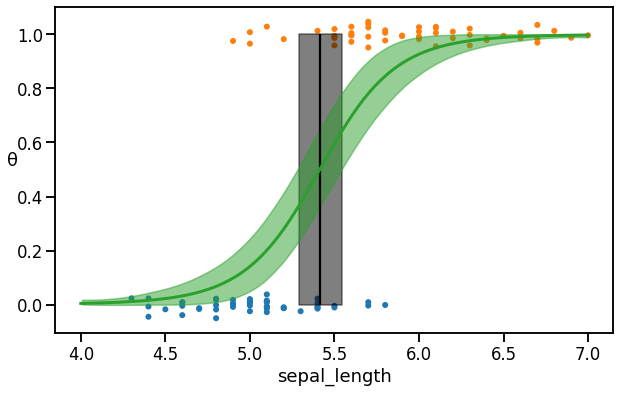

In [60]:
_, ax = plt.subplots(figsize=(10,6))
fp = logistic(pred_samples['f_pred'])
fp_mean = np.mean(fp, 0)
ax.scatter(x_1, np.random.normal(y, 0.02), marker='.',
color=[f'C{ci}' for ci in y])
db = np.array([find_midpoint(f, X_new[:,0], 0.5) for f in fp])
db_mean = db.mean()
db_hpd = az.hpd(db)
ax.vlines(db_mean, 0, 1, color='k')
ax.fill_betweenx([0, 1], db_hpd[0], db_hpd[1], color='k', alpha=0.5)
ax.plot(X_new[:,0], fp_mean, 'C2', lw=3)
az.plot_hpd(X_new[:,0], fp, color='C2')
ax.set_xlabel('sepal_length')
ax.set_ylabel('θ', rotation=0)

For these kinds of issues, it doesn't make much sense to make GaussianProcesses, as we can easily model them well with simple logistic regressions and the like. Let's turn to some more complicated stuff:

## The tale of the tails of age

[Text(0, 0, 'healthy'), Text(0, 1, 'sick')]

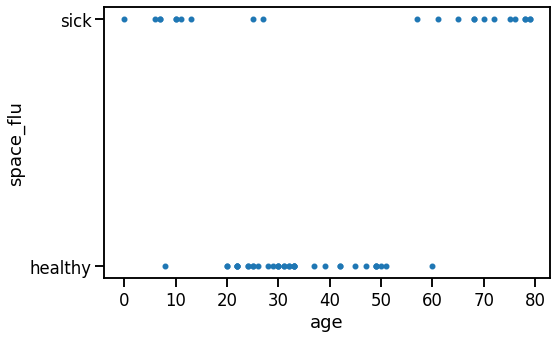

In [62]:
df_sf = pd.read_csv('../data/space_flu.csv')
age = df_sf.age.values[:, None]
space_flu = df_sf.space_flu
ax = df_sf.plot.scatter('age', 'space_flu', figsize=(8, 5))
ax.set_yticks([0, 1])
ax.set_yticklabels(['healthy', 'sick'])

In [63]:
with pm.Model() as model_space_flu:
    ℓ = pm.HalfCauchy('ℓ', 1)
    cov = pm.gp.cov.ExpQuad(1, ℓ) + pm.gp.cov.WhiteNoise(1E-5)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior('f', X=age)
    y_ = pm.Bernoulli('y', p=pm.math.sigmoid(f), observed=space_flu)
    trace_space_flu = pm.sample(
    1000, chains=1, compute_convergence_checks=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [f_rotated_, ℓ]


C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\pymc3\math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 22 seconds.


In [64]:
X_new = np.linspace(0, 80, 200)[:, None]
with model_space_flu:
    f_pred = gp.conditional('f_pred', X_new)
    pred_samples = pm.sample_posterior_predictive(trace_space_flu,
    var_names =["f_pred"],
    samples=1000)

Text(0.5, 0, 'age')

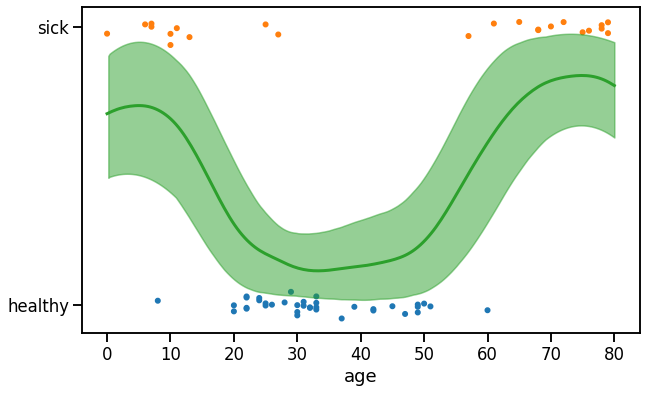

In [65]:
_, ax = plt.subplots(figsize=(10, 6))
fp = logistic(pred_samples['f_pred'])
fp_mean = np.nanmean(fp, 0)
ax.scatter(age, np.random.normal(space_flu, 0.02),
marker='.', color=[f'C{ci}' for ci in space_flu])
ax.plot(X_new[:, 0], fp_mean, 'C2', lw=3)
az.plot_hpd(X_new[:, 0], fp, color='C2')
ax.set_yticks([0, 1])
ax.set_yticklabels(['healthy', 'sick'])
ax.set_xlabel('age')

## Are we getting Coxy?
Modelling Poisson likelihoods with Cox Processes on the coal mining dataset:

In [66]:
coal_df = pd.read_csv('../data/coal.csv', header=None)
coal_df.head()

,0
0,1851.2026
1,1851.6324
2,1851.9692
3,1851.9747
4,1852.3142


In [67]:
# discretize data
years = int(coal_df.max().values - coal_df.min().values)
bins = years // 4
hist, x_edges = np.histogram(coal_df, bins=bins)
# compute the location of the centers of the discretized data
x_centers = x_edges[:-1] + (x_edges[1] - x_edges[0]) / 2
# arrange xdata into proper shape for GP
x_data = x_centers[:, None]
# express data as the rate number of disaster per year
y_data = hist / 4

In [68]:
with pm.Model() as model_coal:
    ℓ = pm.HalfNormal('ℓ', x_data.std())
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ) + pm.gp.cov.WhiteNoise(1E-5)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior('f', X=x_data)
    y_pred = pm.Poisson('y_pred', mu=pm.math.exp(f), observed=y_data)
    trace_coal = pm.sample(1000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [f_rotated_, ℓ]


C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\pymc3\math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 12 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\arviz\utils.py:660: UserWarning: Keyword argument credible_interval has been deprecated Please replace with hdi_prob
  warnings.warn(


Text(0, 0.5, 'rate')

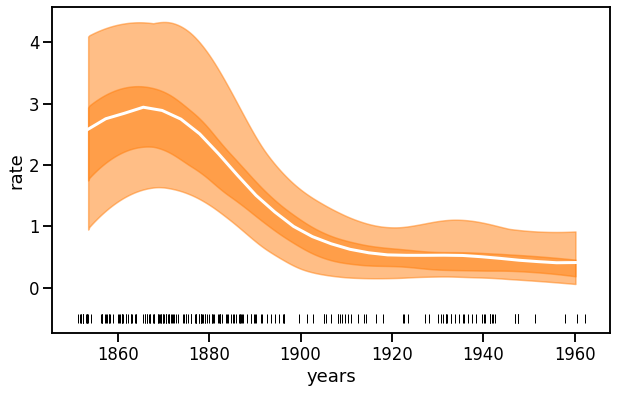

In [69]:
_, ax = plt.subplots(figsize=(10, 6))
f_trace = np.exp(trace_coal['f'])
rate_median = np.median(f_trace, axis=0)
ax.plot(x_centers, rate_median, 'w', lw=3)
az.plot_hpd(x_centers, f_trace)
az.plot_hpd(x_centers, f_trace, credible_interval=0.5,
plot_kwargs={'alpha': 0})
ax.plot(coal_df, np.zeros_like(coal_df)-0.5, 'k|')
ax.set_xlabel('years')
ax.set_ylabel('rate')

WHY ARE THESE PLOTS SO COOL?!

## MORE GAUSSIAN PROCESS!!!!!!

Text(0, 0.5, 'x2 coordinate')

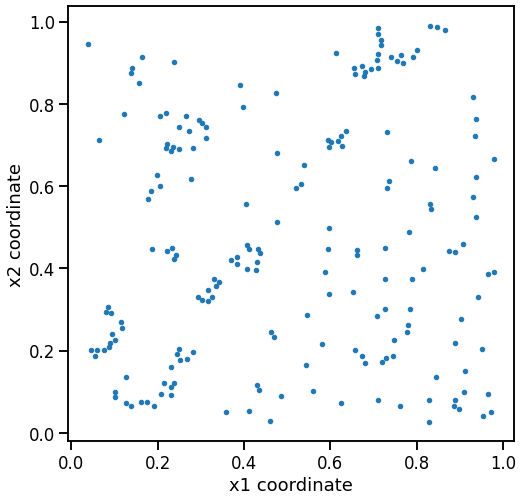

In [70]:
rw_df = pd.read_csv('../data/redwood.csv', header=None)
_, ax = plt.subplots(figsize=(8, 8))
ax.plot(rw_df[0], rw_df[1], 'C0.')
ax.set_xlabel('x1 coordinate')
ax.set_ylabel('x2 coordinate')

In [71]:
# discretize spatial data
bins = 20
hist, x1_edges, x2_edges = np.histogram2d(
rw_df[1].values, rw_df[0].values, bins=bins)
# compute the location of the centers of the discretized data
x1_centers = x1_edges[:-1] + (x1_edges[1] - x1_edges[0]) / 2
x2_centers = x2_edges[:-1] + (x2_edges[1] - x2_edges[0]) / 2
# arrange xdata into proper shape for GP
x_data = [x1_centers[:, None], x2_centers[:, None]]
# arrange ydata into proper shape for GP
y_data = hist.flatten()

In [72]:
with pm.Model() as model_rw:
    ℓ = pm.HalfNormal('ℓ', rw_df.std().values, shape=2)
    cov_func1 = pm.gp.cov.ExpQuad(1, ls=ℓ[0])
    cov_func2 = pm.gp.cov.ExpQuad(1, ls=ℓ[1])
    gp = pm.gp.LatentKron(cov_funcs=[cov_func1, cov_func2])
    f = gp.prior('f', Xs=x_data)
    y = pm.Poisson('y', mu=pm.math.exp(f), observed=y_data)
    trace_rw = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [f_rotated_, ℓ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 132 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


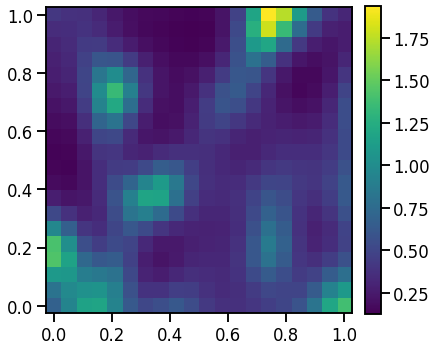

In [73]:
rate = np.exp(np.mean(trace_rw['f'], axis=0).reshape((bins, -1)))
fig, ax = plt.subplots(figsize=(6, 6))
ims = ax.imshow(rate, origin='lower')
ax.grid(False)
ticks_loc = np.linspace(0, bins-1, 6)
ticks_lab = np.linspace(0, 1, 6).round(1)
ax.set_xticks(ticks_loc)
ax.set_yticks(ticks_loc)
ax.set_xticklabels(ticks_lab)
ax.set_yticklabels(ticks_lab)
cbar = fig.colorbar(ims, fraction=0.046, pad=0.04)

# WILD! WHAT A FUCKING CRAZY RIDE! THESE PLOTS! THE POWER! THE GLORY!

# Exercises
## Exercise 1: King Kernel
For the example in the Covariance functions and kernels section make sure you
understand the relationship between the input data and the generated
covariance matrix. Try using other input such as data =
np.random.normal(size=4)

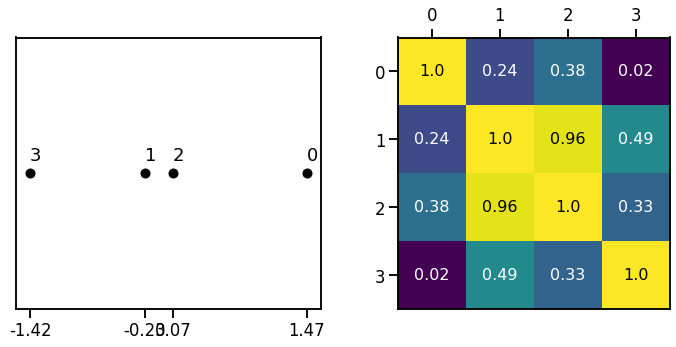

In [4]:
data = np.random.normal(size=4)
cov = exp_quad_kernel(data, data, 1)
_, ax = plt.subplots(1, 2, figsize=(12, 5))
ax = np.ravel(ax)
ax[0].plot(data, np.zeros_like(data), 'ko')
ax[0].set_yticks([])
for idx, i in enumerate(data):
    ax[0].text(i, 0+0.005, idx)
ax[0].set_xticks(data)
ax[0].set_xticklabels(np.round(data, 2))
#ax[0].set_xticklabels(np.round(data, 2), rotation=70)
ax[1].grid(False)
im = ax[1].imshow(cov)
colors = ['w', 'k']
for i in range(len(cov)):
    for j in range(len(cov)):
        ax[1].text(j, i, round(cov[i, j], 2),
        color=colors[int(im.norm(cov[i, j]) > 0.5)],
        ha='center', va='center', fontdict={'size': 16})
ax[1].set_xticks(range(len(data)))
ax[1].set_yticks(range(len(data)))
ax[1].xaxis.tick_top()

So notice again that this is symmetric, so we only need to understand everything below the diagonal :)
It almost works as a distance metric. So 0 is very far from 3, and therefore the last entry is almost 0 - the two points have very little in common. On the opposite side of the spectrum is 1 and 2, which has very similar values, which would mean that they are close to each other, reflected in a large value. The distance analogue also works with how 1 and two relates to 3 and 0. 

## Exercise 2: Sampling samples
Rerun the code generating Figure 7.3 and increase the number of samples
obtained from the GP-prior to around 200. In the original figure the number of
samples is 2. Which is the range of the generated values?

The generated values seems to be centered around 0, but seems to be able to go above 4 and below -3.

Text(-0.03, 0.5, 'f(x)')

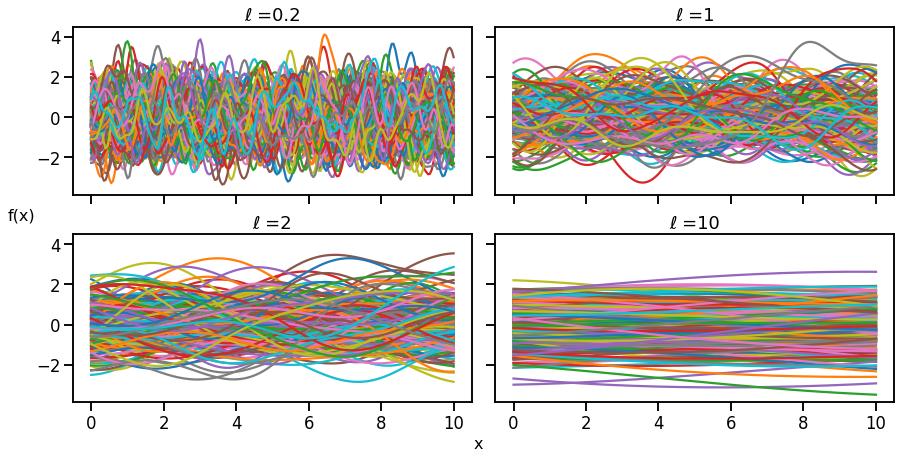

In [10]:
np.random.seed(24)
test_points = np.linspace(0, 10, 200) #200, fuck is this guy on about
fig, ax = plt.subplots(2, 2, figsize=(12, 6), sharex=True, sharey=True, constrained_layout=True)
ax = np.ravel(ax)

for idx, ℓ in enumerate((0.2, 1, 2, 10)):
    cov = exp_quad_kernel(test_points, test_points, ℓ)
    ax[idx].plot(test_points, stats.multivariate_normal.rvs(cov=cov,
    size=200).T)
    ax[idx].set_title(f'ℓ ={ℓ}')
fig.text(0.51, -0.03, 'x', fontsize=16)
fig.text(-0.03, 0.5, 'f(x)', fontsize=16)

## Exercise 3: Is there a standard between standard deviations?
For the generated plot in the previous exercise. Compute the standard deviation
for the values of at each point. Do this in the following form:
1. Visually, just observing the plots
2. Directly from the values generated from
stats.multivariate_normal.rvs
3. By inspecting the covariance matrix (if you have doubts go back to
exercise 1)

Did the values you get from these 3 methods agree?

Text(-0.03, 0.5, 'f(x)')

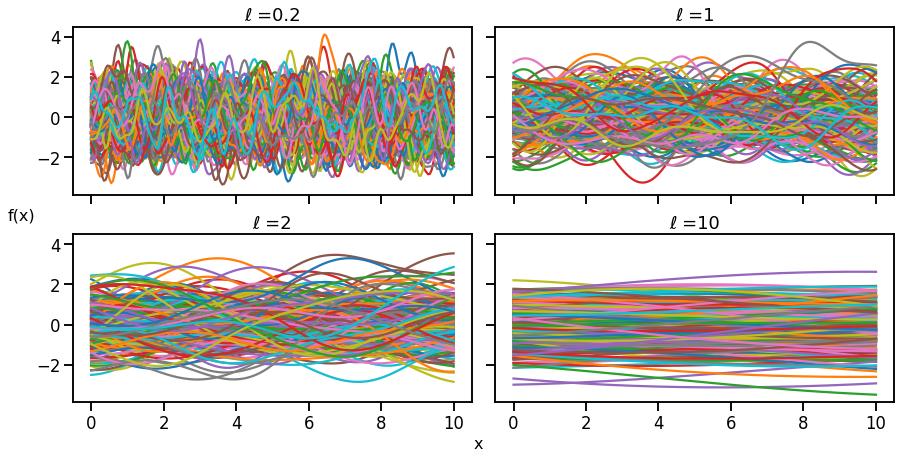

In [11]:
np.random.seed(24)
test_points = np.linspace(0, 10, 200) #200, fuck is this guy on about
fig, ax = plt.subplots(2, 2, figsize=(12, 6), sharex=True, sharey=True, constrained_layout=True)
ax = np.ravel(ax)

for idx, ℓ in enumerate((0.2, 1, 2, 10)):
    cov = exp_quad_kernel(test_points, test_points, ℓ)
    ax[idx].plot(test_points, stats.multivariate_normal.rvs(cov=cov,
    size=200).T)
    ax[idx].set_title(f'ℓ ={ℓ}')
fig.text(0.51, -0.03, 'x', fontsize=16)
fig.text(-0.03, 0.5, 'f(x)', fontsize=16)

Hmm... Not quite sure I understand. Should this be done for each of the subplots? Let's just do that. My intuition would say that for larger... ℓ, we would have a lower sd. It looks like points vary a lot more without the smoothing. 

Text(-0.03, 0.5, 'f(x)')

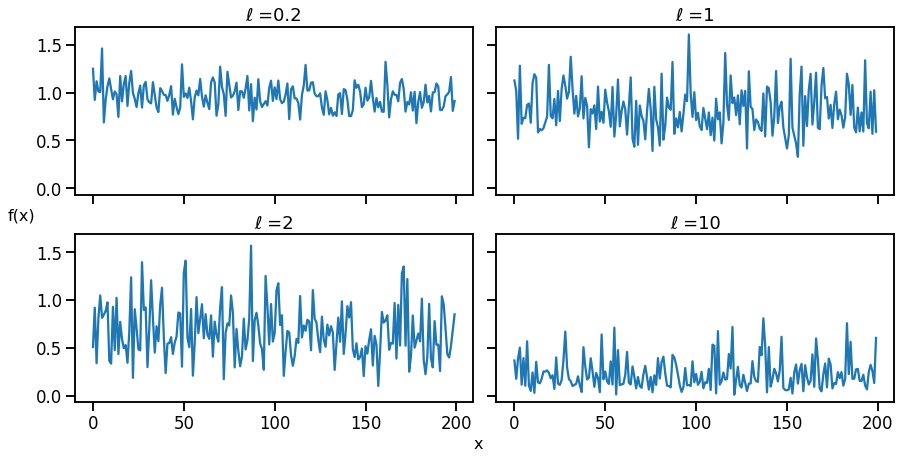

In [28]:
np.random.seed(24)
test_points = np.linspace(0, 10, 200) #200, fuck is this guy on about
fig, ax = plt.subplots(2, 2, figsize=(12, 6), sharex=True, sharey=True, constrained_layout=True)
ax = np.ravel(ax)

for idx, ℓ in enumerate((0.2, 1, 2, 10)):
    cov = exp_quad_kernel(test_points, test_points, ℓ)
    multi = stats.multivariate_normal.rvs(cov=cov,
    size=200)
    ax[idx].plot(multi.std(axis = 1))
    ax[idx].set_title(f'ℓ ={ℓ}')
fig.text(0.51, -0.03, 'x', fontsize=16)
fig.text(-0.03, 0.5, 'f(x)', fontsize=16)

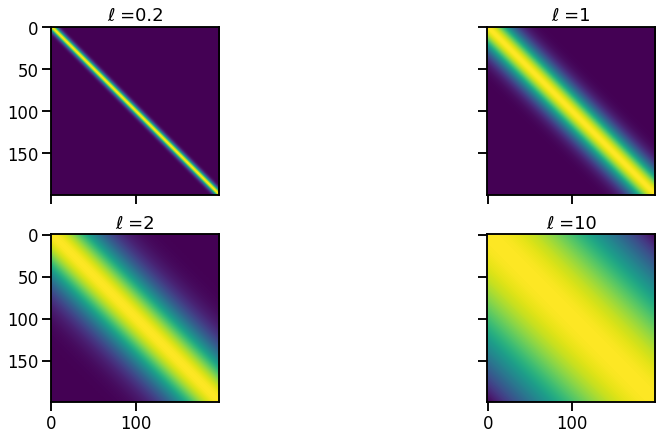

In [33]:
np.random.seed(24)
test_points = np.linspace(0, 10, 200) #200, fuck is this guy on about
fig, ax = plt.subplots(2, 2, figsize=(12, 6), sharex=True, sharey=True, constrained_layout=True)
ax = np.ravel(ax)

for idx, ℓ in enumerate((0.2, 1, 2, 10)):
    cov = exp_quad_kernel(test_points, test_points, ℓ)
    ax[idx].grid(False)
    im = ax[idx].imshow(cov)
    colors = ['w', 'k']
    ax[idx].set_title(f'ℓ ={ℓ}')


This is a really good way of visualizing what the weird ℓ parameter does. It adjusts how much the points are taken to be similar to their neighbors. This is also why the standard deviation dramatically drops for large ℓs. Most values are very similar, whereas for small ℓ's, the values have very little to do with one another.

## Exercise 4: Re-re-rerun the regression, DJ
Re-run the model model_reg and get new plots but using as
test_points X_new np.linspace(np.floor(x.min()), 20,
100)[:,None]. What did you observed? How is this related to the specification
of the GP-prior?

Text(0, 0.5, 'f(x)')

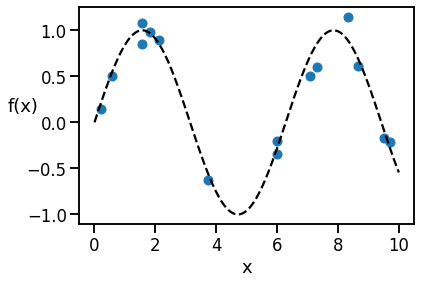

In [40]:
np.random.seed(42)
x = np.random.uniform(0, 10, size=15)
y = np.random.normal(np.sin(x), 0.1)
plt.plot(x, y, 'o')
true_x = np.linspace(0, 10, 200)
plt.plot(true_x, np.sin(true_x), 'k--')
plt.xlabel('x')
plt.ylabel('f(x)', rotation=0)

In [41]:
# A one dimensional column vector of inputs.
X = x[:, None]
with pm.Model() as model_reg:
    # hyperprior for lengthscale kernel parameter
    ℓ = pm.Gamma('ℓ', 2, 0.5)
    # instantiate a covariance function
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ)
    # instantiate a GP prior
    gp = pm.gp.Marginal(cov_func=cov)
    # prior
    ϵ = pm.HalfNormal('ϵ', 25)
    # likelihood
    y_pred = gp.marginal_likelihood('y_pred', X=X, y=y, noise=ϵ)

In [42]:
with model_reg:
    trace_reg = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, ℓ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 76 seconds.


In [43]:
X_new = np.linspace(np.floor(x.min()), 20, 100)[:,None] #define new data that the model should predict on
with model_reg:
    f_pred = gp.conditional('f_pred', X_new) #get f_pred, which is our predicted functions 

In [44]:
with model_reg:
    pred_samples = pm.sample_posterior_predictive(trace_reg, var_names=["f_pred"], samples=82) #proper syntax as of 2021

C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


Text(0, 0.5, 'f(x)')

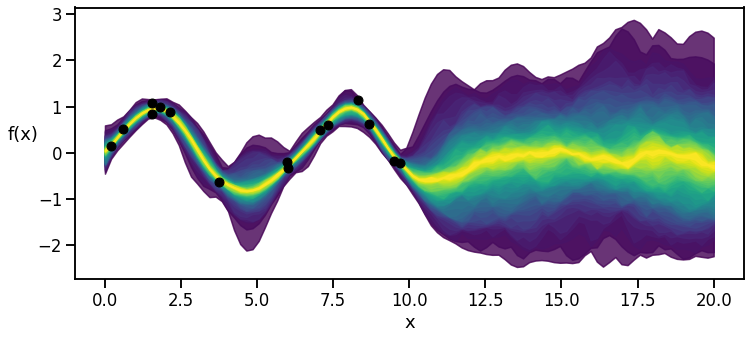

In [45]:
_, ax = plt.subplots(figsize=(12,5))
pm.gp.util.plot_gp_dist(ax, pred_samples['f_pred'], X_new,
palette='viridis', plot_samples=False); #DEN HER BADBOY HVAD SKER DER
ax.plot(X, y, 'ko')
ax.set_xlabel('x')
ax.set_ylabel('f(x)', rotation=0, labelpad=15)

So the problem is now that we are trying to predict outside the range where we have seen data. The GP prior must have some specification where this information is stored. It can't really optimize its posterior, so it must use its priors somewhat directly for the stuff outside of its training range.

## Exercise 5: Longing for Linear Regressions
Go back to exercise 1, but this time use a linear kernel (see the accompanying
code for a linear kernel)

In [47]:
def linear_kernel(x, knots):
    """ linear kernel """
    return np.array([(x - 2) * (k - 2) for k in knots])

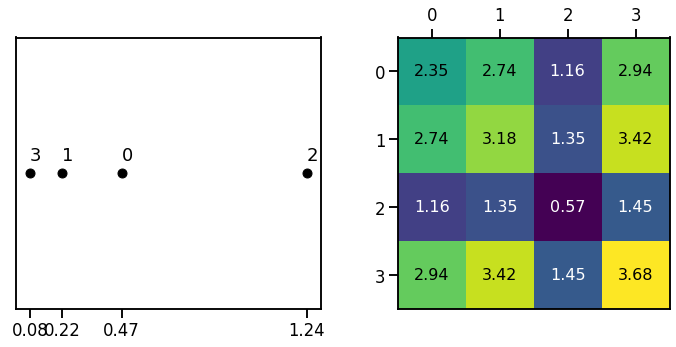

In [49]:
data = np.random.normal(size=4)
cov = linear_kernel(data, data)
_, ax = plt.subplots(1, 2, figsize=(12, 5))
ax = np.ravel(ax)
ax[0].plot(data, np.zeros_like(data), 'ko')
ax[0].set_yticks([])
for idx, i in enumerate(data):
    ax[0].text(i, 0+0.005, idx)
ax[0].set_xticks(data)
ax[0].set_xticklabels(np.round(data, 2))
#ax[0].set_xticklabels(np.round(data, 2), rotation=70)
ax[1].grid(False)
im = ax[1].imshow(cov)
colors = ['w', 'k']
for i in range(len(cov)):
    for j in range(len(cov)):
        ax[1].text(j, i, round(cov[i, j], 2),
        color=colors[int(im.norm(cov[i, j]) > 0.5)],
        ha='center', va='center', fontdict={'size': 16})
ax[1].set_xticks(range(len(data)))
ax[1].set_yticks(range(len(data)))
ax[1].xaxis.tick_top()

Still somewhat works, but the diagonal is completely crazy to interpret now. But the intuition really falls apart. 

## Exercise 6: The Return of the Notebooks
Go and check the section https:/​/​docs.​pymc.​io/​notebooks/​GP-​MeansAndCovs.
html from PyMC3' documentation

In [1]:
import matplotlib.cm as cmap
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano
import theano.tensor as tt

%matplotlib inline

np.random.seed(206)

In [2]:
zero_func = pm.gp.mean.Zero()

X = np.linspace(0, 1, 5)[:, None]
print(zero_func(X).eval())

[0. 0. 0. 0. 0.]


In [3]:
const_func = pm.gp.mean.Constant(25.2)

print(const_func(X).eval())

[25.2 25.2 25.2 25.2 25.2]


In [4]:
const_func_vec = pm.gp.mean.Constant(tt.ones(5))

print(const_func_vec(X).eval())

[1. 1. 1. 1. 1.]


In [5]:
beta = np.random.randn(3)
b = 0.0

lin_func = pm.gp.mean.Linear(coeffs=beta, intercept=b)

X = np.random.randn(5, 3)
print(lin_func(X).eval())

[-0.36242716  2.20718024  0.41039522  2.50735445 -2.06177178]


In [8]:
import theano.tensor as tt

class Constant(pm.gp.mean.Mean):

    def __init__(self, c=0):
        Mean.__init__(self)
        self.c = c

    def __call__(self, X):
        return tt.alloc(1.0, X.shape[0]) * self.c

In [11]:
lengthscale = 0.2
eta = 2.0
cov = eta ** 2 * pm.gp.cov.ExpQuad(1, lengthscale)

X = np.linspace(0, 2, 200)[:, None]
K = cov(X).eval()

In [19]:
plt.figure(figsize=(14, 4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T)
plt.title("Samples from the GP prior")
plt.ylabel("y")
plt.xlabel("X");

ValueError: input operand has more dimensions than allowed by the axis remapping

<Figure size 1008x288 with 0 Axes>

Doesn't work. For 2 dimensions:

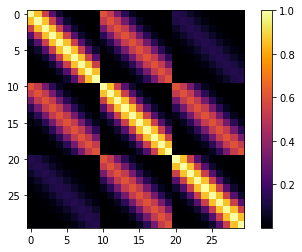

In [21]:
x1, x2 = np.meshgrid(np.linspace(0, 1, 10), np.arange(1, 4))
X2 = np.concatenate((x1.reshape((30, 1)), x2.reshape((30, 1))), axis=1)

ls = np.array([0.2, 1.0])
cov = pm.gp.cov.ExpQuad(input_dim=2, ls=ls)

K = theano.function([], cov(X2))()
m = plt.imshow(K, cmap="inferno", interpolation="none")
plt.colorbar(m);

Works and looks cool. Only one dimension active:

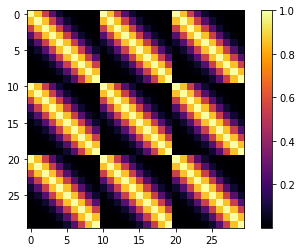

In [22]:
ls = 0.2
cov = pm.gp.cov.ExpQuad(input_dim=2, ls=ls, active_dims=[0])

K = theano.function([], cov(X2))()
m = plt.imshow(K, cmap="inferno", interpolation="none")
plt.colorbar(m);

Using the product of the two covariance matrices gives the same as the above code:


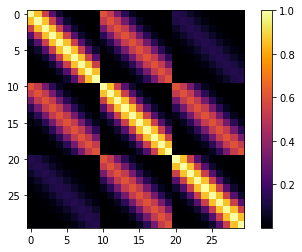

In [23]:
ls1 = 0.2
ls2 = 1.0
cov1 = pm.gp.cov.ExpQuad(2, ls1, active_dims=[0])
cov2 = pm.gp.cov.ExpQuad(2, ls2, active_dims=[1])
cov = cov1 * cov2

K = theano.function([], cov(X2))()
m = plt.imshow(K, cmap="inferno", interpolation="none")
plt.colorbar(m);

#### JUST NOISE, WHITE NOISE

In [30]:
sigma = 2.0
cov = pm.gp.cov.WhiteNoise(sigma)

X = np.linspace(0, 2, 200)[:, None]
K = cov(X).eval()

plt.figure(figsize=(14, 4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T)
plt.title("Samples from the GP prior")
plt.ylabel("y")
plt.xlabel("X");

ValueError: input operand has more dimensions than allowed by the axis remapping

<Figure size 1008x288 with 0 Axes>

In [33]:
c = 2.0
cov = pm.gp.cov.Constant(c)

X = np.linspace(0, 2, 200)[:, None]
K = cov(X).eval()

plt.figure(figsize=(14, 4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T)
plt.title("Samples from the GP prior")
plt.ylabel("y")
plt.xlabel("X");

ValueError: input operand has more dimensions than allowed by the axis remapping

<Figure size 1008x288 with 0 Axes>

In [34]:
alpha = 0.1
ls = 0.2
tau = 2.0
cov = tau * pm.gp.cov.RatQuad(1, ls, alpha)

X = np.linspace(0, 2, 200)[:, None]
K = cov(X).eval()

plt.figure(figsize=(14, 4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T)
plt.title("Samples from the GP prior")
plt.ylabel("y")
plt.xlabel("X");

ValueError: input operand has more dimensions than allowed by the axis remapping

<Figure size 1008x288 with 0 Axes>

GIVING UP! THIS FUCKING NOTEBOOK IS BEYOND SAVING!

## Exercise 7: Back to Logic and Logistic Regressions
Run a logistic regression model for the space_flu data. What do you see? Can
you explain the result?

[Text(0, 0, 'healthy'), Text(0, 1, 'sick')]

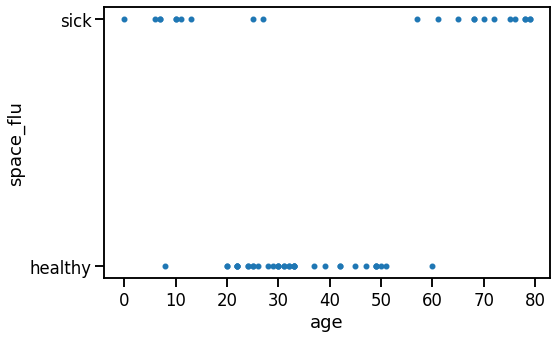

In [38]:
df_sf = pd.read_csv('../data/space_flu.csv')
age = df_sf.age.values
space_flu = df_sf.space_flu
ax = df_sf.plot.scatter('age', 'space_flu', figsize=(8, 5))
ax.set_yticks([0, 1])
ax.set_yticklabels(['healthy', 'sick'])

In [36]:
y_0 = pd.Categorical(df_sf['space_flu']).codes

In [40]:
x_c = (age - age.mean())/age.std()

In [41]:
with pm.Model() as model_rlg:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10)
    μ = α + x_c * β
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -α/β)
    π = pm.Beta('π', 1., 1.)
    p = π * 0.5 + (1 - π) * θ
    yl = pm.Bernoulli('yl', p=p, observed=y_0)
    trace_rlg = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [π, β, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 83 seconds.
The acceptance probability does not match the target. It is 0.7172742015177896, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [42]:
az.summary(trace_rlg)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,-9.837,3.919,-17.511,-3.568,0.150,0.106,682.0,682.0,630.0,808.0,1.01
β,11.491,4.668,3.707,19.911,0.180,0.128,670.0,670.0,622.0,681.0,1.00
θ[0],0.070,0.104,0.000,0.260,0.003,0.002,1209.0,1209.0,1253.0,1297.0,1.00
θ[1],0.000,0.001,0.000,0.000,0.000,0.000,824.0,824.0,594.0,677.0,1.00
θ[2],0.000,0.000,0.000,0.000,0.000,0.000,938.0,938.0,593.0,665.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...
θ[57],0.004,0.014,0.000,0.012,0.001,0.000,699.0,699.0,641.0,779.0,1.01
θ[58],0.000,0.003,0.000,0.001,0.000,0.000,743.0,743.0,601.0,719.0,1.01
θ[59],0.000,0.002,0.000,0.001,0.000,0.000,772.0,772.0,598.0,741.0,1.01
bd,0.876,0.182,0.551,1.202,0.004,0.003,2403.0,2176.0,2508.0,1493.0,1.00


array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'θ'}>,
        <AxesSubplot:title={'center':'θ'}>],
       [<AxesSubplot:title={'center':'bd'}>,
        <AxesSubplot:title={'center':'bd'}>],
       [<AxesSubplot:title={'center':'π'}>,
        <AxesSubplot:title={'center':'π'}>]], dtype=object)

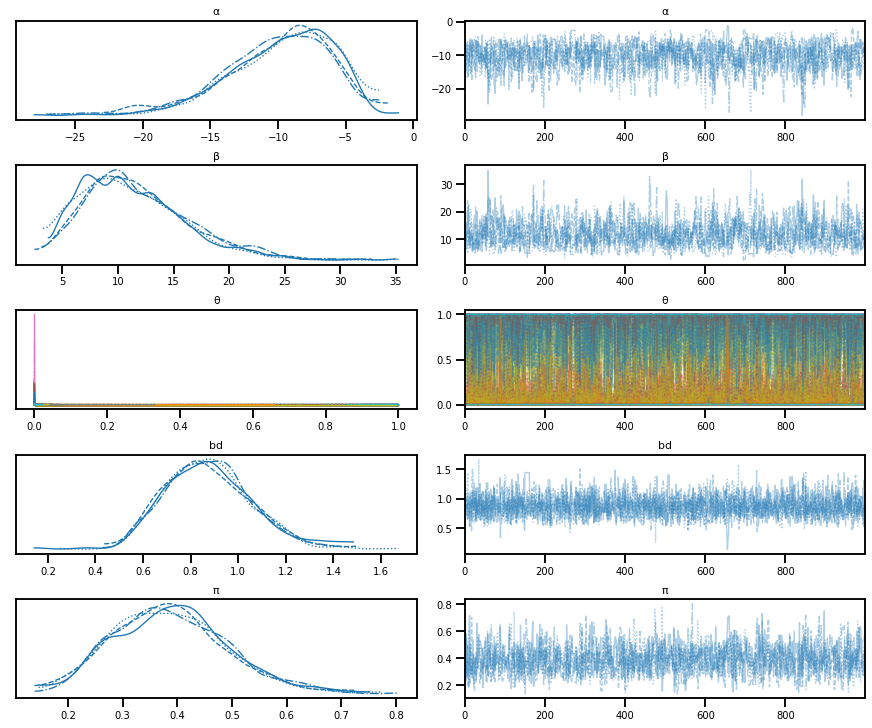

In [43]:
az.plot_trace(trace_rlg)

C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\arviz\stats\stats.py:340: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(


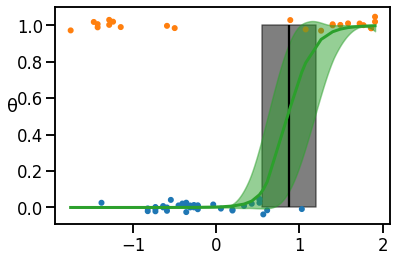

In [47]:
theta = trace_rlg['θ'].mean(axis=0)
idx = np.argsort(x_c)
plt.plot(x_c[idx], theta[idx], color='C2', lw=3)
plt.vlines(trace_rlg['bd'].mean(), 0, 1, color='k')
bd_hpd = az.hpd(trace_rlg['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='k', alpha=0.5)
plt.scatter(x_c, np.random.normal(y_0, 0.02), marker='.', color=[f'C{x}' for x in y_0])
az.plot_hpd(x_c, trace_rlg['θ'], color='C2')
#plt.xlabel(x_n)
plt.ylabel('θ', rotation=0)
# use original scale for xticks
locs, _ = plt.xticks()

## Exercise 8: Double the Beta's, double the fun
Change the logistic regression model in order to fit the data. Tip, use an order
two polynomial.

In [58]:
xs = np.vstack((x_c, x_c**2)).T

In [60]:
with pm.Model() as model_rlg2:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10, shape = 2)
    μ = α + pm.math.dot(xs, β)
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    #bd = pm.Deterministic('bd', -α/β)
    π = pm.Beta('π', 1., 1.)
    p = π * 0.5 + (1 - π) * θ
    yl = pm.Bernoulli('yl', p=p, observed=y_0)
    trace_rlg2 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [π, β, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7073597392111629, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [63]:
az.summary(trace_rlg2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,-10.185,4.207,-17.504,-3.130,0.230,0.163,333.0,333.0,229.0,134.0,1.02
β[0],1.886,2.612,-2.988,6.772,0.081,0.063,1047.0,863.0,1137.0,1263.0,1.01
β[1],12.100,5.215,3.628,21.282,0.282,0.199,342.0,342.0,246.0,182.0,1.02
θ[0],0.026,0.052,0.000,0.107,0.002,0.001,774.0,774.0,469.0,850.0,1.01
θ[1],0.037,0.065,0.000,0.156,0.004,0.003,214.0,214.0,391.0,412.0,1.01
...,...,...,...,...,...,...,...,...,...,...,...
θ[56],0.037,0.065,0.000,0.156,0.004,0.003,214.0,214.0,391.0,412.0,1.01
θ[57],0.002,0.007,0.000,0.012,0.001,0.000,120.0,120.0,232.0,134.0,1.02
θ[58],0.004,0.010,0.000,0.018,0.001,0.001,104.0,104.0,223.0,134.0,1.02
θ[59],0.007,0.017,0.000,0.031,0.002,0.001,99.0,99.0,238.0,151.0,1.02


array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'θ'}>,
        <AxesSubplot:title={'center':'θ'}>],
       [<AxesSubplot:title={'center':'π'}>,
        <AxesSubplot:title={'center':'π'}>]], dtype=object)

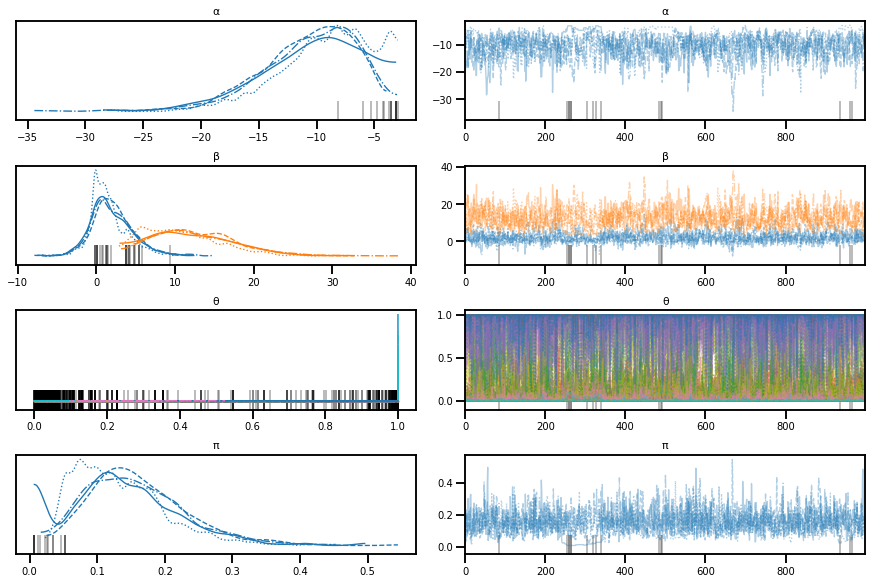

In [64]:
az.plot_trace(trace_rlg2)

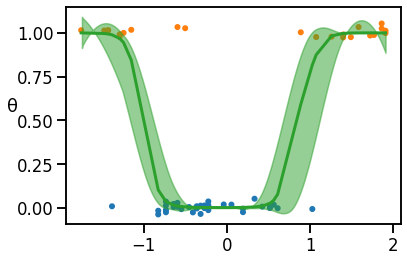

In [62]:
theta = trace_rlg2['θ'].mean(axis=0)
idx = np.argsort(x_c)
plt.plot(x_c[idx], theta[idx], color='C2', lw=3)
plt.scatter(x_c, np.random.normal(y_0, 0.02), marker='.', color=[f'C{x}' for x in y_0])
az.plot_hpd(x_c, trace_rlg2['θ'], color='C2')
#plt.xlabel(x_n)
plt.ylabel('θ', rotation=0)
# use original scale for xticks
locs, _ = plt.xticks()

Question: How would we describe the decision boundary when we have two $\beta$?

## Exercise 9: Coal miners are Cool miners
Compare the model for the coal mining disaster with the one from the PyMC3
documentation (https:/​/​docs.​pymc.​io/​notebooks/​getting_​started.
html#Case-​study-​2:-​Coal-​mining-​disasters). Describe the differences between
both models in terms of model-specification and results.

This is the change-point example. Recall that the previous plot we did just explored different functions that could fit the data using a Cox process. In the notebook, the general idea was to estimate the change point in the data. We can see a similar result in our plot, if we look at the derivative of the median function. The models are describing the data in quite different ways. In the notebook, we are getting estimates in our posterior, whereas the Cox process gives us different functions. 